## PVNet LineMod

In [1]:
import os
import sys
sys.path.append('.')
sys.path.append('..')
sys.path.append('../../')

import numpy as np
from PIL import Image, ImageFile

from config.config import cfg

In [2]:
class LineModModelDB(object):
    """LineModModelDBは、各モデルのメッシュを管理するために使用されます

    """
    corners_3d = {}
    models = {}
    diameters = {}
    centers_3d = {}
    farthest_3d = {'8': {},
                                  '4': {},
                                  '12': {},
                                  '16': {},
                                  '20': {}}
    small_bbox_corners = {}

    def __init__(self):
        """LineModModelDB を初期化します.
        """

        self.linemod_dir = cfg.LINEMOD_DIR
        self.pvnet_linemod_dir = cfg.PVNET_LINEMOD_DIR

        self.ply_pattern = os.path.join(self.pvnet_linemod_dir, '{}/{}.ply')
        self.diameter_pattern = os.path.join(self.linemod_dir, '{}/distance.txt')
        self.farthest_pattern = os.path.join(self.pvnet_linemod_dir, '{}/farthest{}.txt')


    def get_centers_3d(self, object_name):
        if object_name in self.centers_3d:
            return self.centers_3d[object_name]

        c3d=self.get_corners_3d(object_name)
        self.centers_3d[object_name]=(np.max(c3d,0)+np.min(c3d,0))/2
        return self.centers_3d[object_name]


    def get_corners_3d(self, object_name: str) -> np.matrix:
        """これは何?

        Arg:
            object_name (str): Integer object id of the Linemod object on which to generate data.

        Return:
            np.matrix: corners_3d データ
        """

        if object_name in self.corners_3d:
            return self.corners_3d[object_name]

        corner_path = os.path.join(self.pvnet_linemod_dir, object_name, 'corners.txt')
        if os.path.exists(corner_path):
            self.corners_3d[object_name] = np.loadtxt(corner_path)
            return self.corners_3d[object_name]

        ply_path = self.ply_pattern.format(object_name, object_name)
        ply = PlyData.read(ply_path)
        data = ply.elements[0].data

        x = data['x']
        min_x, max_x = np.min(x), np.max(x)
        y = data['y']
        min_y, max_y = np.min(y), np.max(y)
        min_z, max_z = np.min(z), np.max(z)
        corners_3d = np.array([
            [min_x, min_y, min_z],
            [min_x, min_y, max_z],
            [min_x, max_y, min_z],
            [min_x, max_y, max_z],
            [max_x, min_y, min_z],
            [max_x, min_y, max_z],
            [max_x, max_y, min_z],
            [max_x, max_y, max_z],
        ])
        self.corners_3d[object_name] = corners_3d
        np.savetxt(corner_path, corners_3d)
        return corners_3d


    def get_diameter(self, object_name):
        if object_name in self.diameters:
            return self.diameters[object_name]

        diameter_path = self.diameter_pattern.format(object_name)
        diameter = np.loadtxt(diameter_path) / 100.
        self.diameters[object_name] = diameter
        return diameter


    def get_farthest_3d(self, object_name, num=8):
        if object_name in self.farthest_3d['{}'.format(num)]:
            return self.farthest_3d['{}'.format(num)][object_name]

        if num==8:
            farthest_path = self.farthest_pattern.format(object_name,'')
        else:
            farthest_path = self.farthest_pattern.format(object_name,num)
        farthest_pts = np.loadtxt(farthest_path)
        self.farthest_3d['{}'.format(num)][object_name] = farthest_pts
        return farthest_pts


    def get_ply_model(self, object_name):
        if object_name in self.models:
            return self.models[object_name]

        ply = PlyData.read(self.ply_pattern.format(object_name, object_name))
        data = ply.elements[0].data
        x = data['x']
        y = data['y']
        z = data['z']
        model = np.stack([x, y, z], axis=-1)
        self.models[object_name] = model
        return model


    def get_small_bbox(self, object_name):
        if object_name in self.small_bbox_corners:
            return self.small_bbox_corners[object_name]

        corners = self.get_corners_3d(object_name)
        center = np.mean(corners,0)
        small_bbox_corners = (corners-center[None,:])*2.0/3.0+center[None,:]
        self.small_bbox_corners[object_name] = small_bbox_corners

        return small_bbox_corners

## インスタンス生成

In [3]:
db = LineModModelDB()

## 3D Plot 用ライブラリをロード

In [6]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## corners_3d Test

In [5]:
object_name = 'ape'

corners_3d = db.get_corners_3d(object_name=object_name)
print('corners_3d = ')
print(corners_3d)
print('shape =', corners_3d.shape)

corners_3d = 
[[-0.03982  -0.04071  -0.035134]
 [-0.03982  -0.04071   0.056635]
 [-0.03982   0.036889 -0.035134]
 [-0.03982   0.036889  0.056635]
 [ 0.036049 -0.04071  -0.035134]
 [ 0.036049 -0.04071   0.056635]
 [ 0.036049  0.036889 -0.035134]
 [ 0.036049  0.036889  0.056635]]
shape = (8, 3)


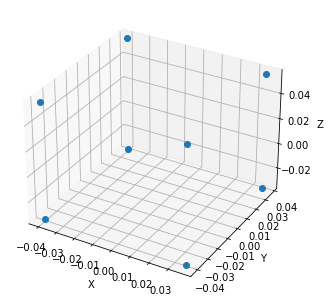

In [7]:
X = []
Y = []
Z = []

for value in corners_3d:
    X.append(value[0])
    Y.append(value[1])
    Z.append(value[2])

# グラフの枠を作成
fig = plt.figure()
ax = Axes3D(fig)

# X,Y,Z軸にラベルを設定
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

# .plotで描画
ax.plot(X, Y, Z, marker="o", linestyle='None')

# 最後に.show()を書いてグラフ表示
plt.show()

## get_small_bbox Test

In [8]:
object_name = 'ape'

small_bbox = db.get_small_bbox(object_name=object_name)
print('small_bbox= ')
print(small_bbox)
print('shape =', small_bbox.shape)

small_bbox= 
[[-0.02717517 -0.02777683 -0.01983917]
 [-0.02717517 -0.02777683  0.04134017]
 [-0.02717517  0.02395584 -0.01983917]
 [-0.02717517  0.02395584  0.04134017]
 [ 0.02340417 -0.02777683 -0.01983917]
 [ 0.02340417 -0.02777683  0.04134017]
 [ 0.02340417  0.02395584 -0.01983917]
 [ 0.02340417  0.02395584  0.04134017]]
shape = (8, 3)


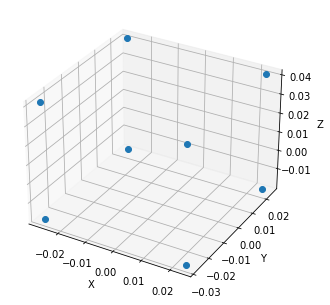

In [9]:
X = []
Y = []
Z = []

for value in small_bbox:
    X.append(value[0])
    Y.append(value[1])
    Z.append(value[2])

# グラフの枠を作成
fig = plt.figure()
ax = Axes3D(fig)

# X,Y,Z軸にラベルを設定
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

# .plotで描画
ax.plot(X, Y, Z, marker="o", linestyle='None')

# 最後に.show()を書いてグラフ表示
plt.show()

## get_ply_mode Test